# Image Classifier

###Check GPU

In [ ]:
!nvidia-smi

Thu Feb 16 04:42:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    30W /  70W |   1326MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-16 04:42:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-16 04:42:18 (94.2 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [ ]:
# Import the helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download data

In [ ]:
# Get TensoFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print(*datasets_list[:10], sep="\n")
print("food101" in datasets_list)

abstract_reasoning
accentdb
aeslc
aflw2k3d
ag_news_subset
ai2_arc
ai2_arc_with_ir
amazon_us_reviews
anli
answer_equivalence
True


In [ ]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

,image,label
0,,56 (huevos_rancheros)
1,,76 (pizza)
2,,21 (chocolate_cake)
3,,64 (miso_soup)

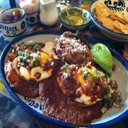
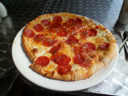
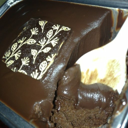
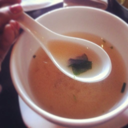

In [ ]:
ds, info = tfds.load('food101', split='train', with_info=True)

tfds.as_dataframe(ds.take(4), info)

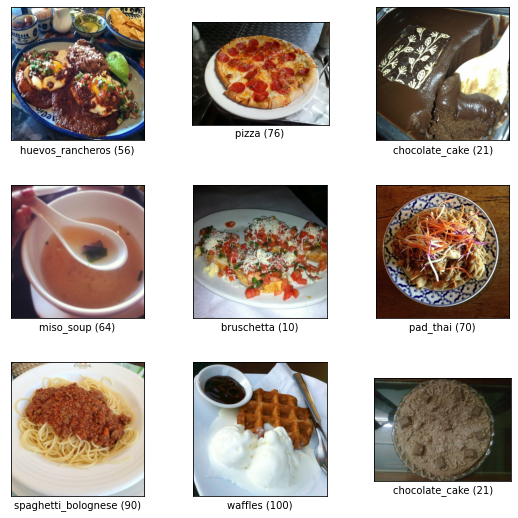

In [ ]:
ds, info = tfds.load('food101', split='train', with_info=True)

fig = tfds.show_examples(ds, info)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo n

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 23
  Class name (str form): churros
  


In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

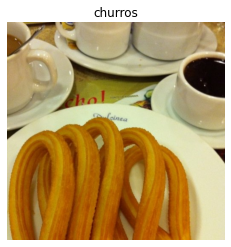

In [ ]:
# Plot the image
import matplotlib.pyplot as plt
plt.title(class_names[label])
plt.axis(False)
plt.imshow(image);

### Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255).

What we know TensorFlow models like to work with:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

In [ ]:
new_data = train_data.map(lambda x, y: (tf.cast(tf.image.resize(x, [224, 224]), tf.float32), y))
new_data

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
def preprocess_image(image, label, img_shape=224):
  """
  Convert image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

### Batch & prepare datasets

We're going to make our data pipeline run really fast.

In [ ]:
# Map preprocessing function to training (and paralleize)
train_data = train_data.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data (and pralleize)
test_data = test_data.map(lambda x, y: preprocess_image(x, y), 
                          num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> Hey TensorFlow, map this preprocessing function (`preprocess_image`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.

### Create modelling callbacks

In [ ]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      save_weights_only=True)

### Setup mixed precision training

**Mixed precision** utilizes a combination of float32 and float16 dtypes to speed up model predictions.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") 

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Creating a feature extraction model capable of using mixed precision training

> **Computations** are done in `float16` for performance, but **variables** must be kept in `float32` for numeric stability.

In [ ]:
print(f"Compute dtype: {mixed_precision.global_policy().compute_dtype}")
print(f"Variable dtype: {mixed_precision.global_policy().variable_dtype}")

Compute dtype: float16
Variable dtype: float32


### Build feature extraction model

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 activation_2 (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

## Checking layer dtype policies (are we using mixed precision)

* `layer.dtype`: the data type a layer stores its variable in
* `layer.dtype_policy`: the data type policy a layer computes on its variable with

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
activation_2 True float32 <Policy "float32">


In [ ]:
for layer in base_model.layers[:10]:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_3 float32 <Policy "float32">
rescaling_4 float32 <Policy "mixed_float16">
normalization_2 float32 <Policy "mixed_float16">
rescaling_5 float32 <Policy "mixed_float16">
stem_conv_pad float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_dwconv float32 <Policy "mixed_float16">
block1a_bn float32 <Policy "mixed_float16">


## Train and feature extract the model


In [ ]:
history = model.fit(train_data, 
                    epochs=10,
                    validation_data=test_data,
                    callbacks=[create_tensorboard_callback(
                        dir_name="tensorboard", experiment_name="feature_extraction"), 
                        model_checkpoint])

Saving TensorBoard log files to: tensorboard/feature_extraction/20230216-044253
Epoch 1/10
2368/2368 [==============================] - 268s 110ms/step - loss: 1.7181 - accuracy: 0.5831 - val_loss: 1.1231 - val_accuracy: 0.7018
Epoch 2/10
2368/2368 [==============================] - 221s 92ms/step - loss: 1.1978 - accuracy: 0.6897 - val_loss: 1.0426 - val_accuracy: 0.7179
Epoch 3/10
2368/2368 [==============================] - 256s 107ms/step - loss: 1.0545 - accuracy: 0.7235 - val_loss: 1.0007 - val_accuracy: 0.7276
Epoch 4/10
2368/2368 [==============================] - 255s 107ms/step - loss: 0.9590 - accuracy: 0.7478 - val_loss: 0.9830 - val_accuracy: 0.7320
Epoch 5/10
2368/2368 [==============================] - 220s 92ms/step - loss: 0.8884 - accuracy: 0.7665 - val_loss: 0.9727 - val_accuracy: 0.7349
Epoch 6/10
2368/2368 [==============================] - 219s 92ms/step - loss: 0.8321 - accuracy: 0.7803 - val_loss: 0.9841 - val_accuracy: 0.7304
Epoch 7/10
2368/2368 [=============

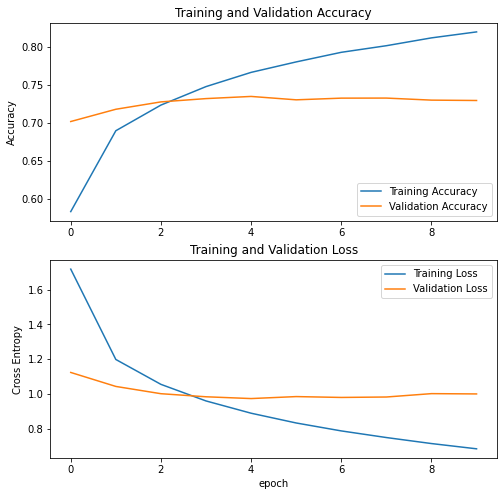

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning the model

#### Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  238


#### Compile the model

As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 activation_2 (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 3,828,269
Non-trainable params: 350,683
___________________________________________

In [ ]:
len(model.trainable_variables)

109

#### Continue training the model

In [ ]:
fine_tune_epochs = 5
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_data)

Epoch 10/15
2368/2368 [==============================] - 322s 125ms/step - loss: 0.3605 - accuracy: 0.8969 - val_loss: 0.9511 - val_accuracy: 0.7628
Epoch 11/15
2368/2368 [==============================] - 268s 113ms/step - loss: 0.1809 - accuracy: 0.9473 - val_loss: 1.0568 - val_accuracy: 0.7608
Epoch 12/15
2368/2368 [==============================] - 271s 113ms/step - loss: 0.1012 - accuracy: 0.9688 - val_loss: 1.2056 - val_accuracy: 0.7512
Epoch 13/15
2368/2368 [==============================] - 265s 111ms/step - loss: 0.0752 - accuracy: 0.9760 - val_loss: 1.2845 - val_accuracy: 0.7571
Epoch 14/15
2368/2368 [==============================] - 298s 125ms/step - loss: 0.0629 - accuracy: 0.9803 - val_loss: 1.2572 - val_accuracy: 0.7676
Epoch 15/15
2368/2368 [==============================] - 265s 111ms/step - loss: 0.0558 - accuracy: 0.9821 - val_loss: 1.3236 - val_accuracy: 0.7620


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

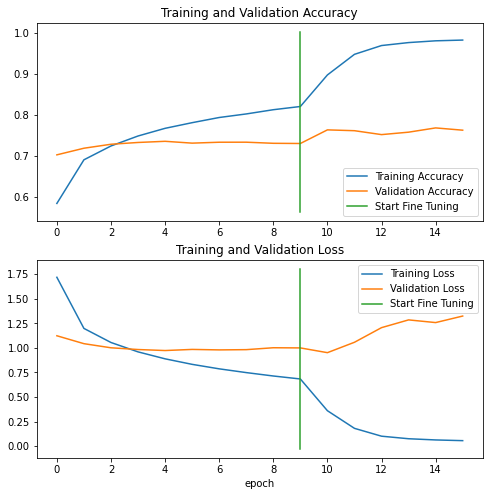

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()